# Imports

In [ ]:
# install rawpy to read raw images,
0.22.0
! pip install rawpy==0.21.0

In [ ]:
# download the 'align' module
! wget https://raw.githubusercontent.com/martin-marek/hdr-plus-pytorch/main/align.py

In [3]:
import os
import io
import requests
import zipfile
import torch
import torchvision
import numpy as np
import align
import rawpy
import imageio
from glob import glob
import matplotlib.pyplot as plt

In [4]:
device = torch.device('cuda')

# Download images

In [5]:
# download and unzip a burst of raw images
if not os.path.exists('burst'):
    r = requests.get('https://pub-e8bbdcbe8f6243b2a9933704a9b1d8bc.r2.dev/bursts%2FMonika-RX100-51200-RAW.zip')
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall('burst')

# Read images

In [6]:
def load_jpeg_images(image_paths):
    """loads rgb pixels from jpeg images"""
    images = []
    for path in image_paths:
        image = torchvision.io.read_image(path)
        image = image.float() / 255
        images.append(image)

    # store the pixels in a tensor
    images = torch.stack(images)

    print(f'burst of shape {list(images.shape)} loaded')
    return images

In [7]:
def load_raw_images(image_paths):
    """loads bayer pixels from raw images"""
    images = []
    for path in image_paths:
        with rawpy.imread(path) as raw:
            image = raw.raw_image.copy().astype(np.float32)
            images.append(image)

    # store the pixels in a tensor with an added "channel" dimension
    images = np.stack(images)
    images = torch.from_numpy(images)[:, None, :, :]

    print(f'burst of shape {list(images.shape)} loaded')
    return images

In [8]:
image_dir = 'burst'
image_paths = sorted(glob(f'{image_dir}/*.*'))
images = load_raw_images(image_paths)

burst of shape [35, 1, 3672, 5504] loaded


# Align images

In [9]:
%%time
merged_image = align.align_and_merge(images, device=device)

CPU times: user 7.65 s, sys: 296 ms, total: 7.94 s
Wall time: 8.83 s


# Plot reference vs. merged image

In [10]:
def get_rgb_values(image_path, bayer_array=None, **kwargs):
    """using a raw file [and modified bayer pixels], get rgb pixels"""
    # open the raw image
    with rawpy.imread(image_path) as raw:
        # overwrite the original bayer array
        if bayer_array is not None:
            raw.raw_image[:] = bayer_array
        # get postprocessed rgb pixels
        rgb = raw.postprocess(**kwargs)
    return rgb

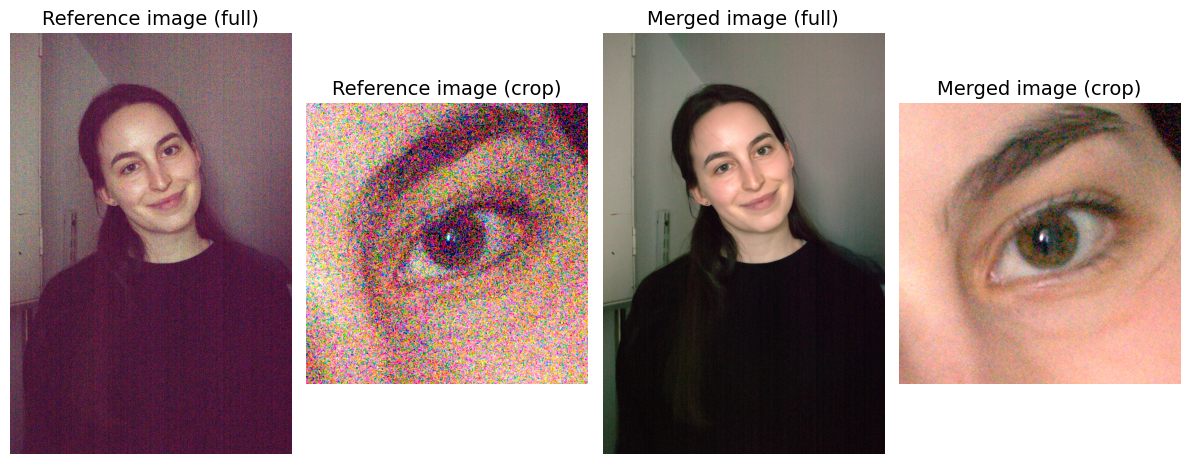

In [11]:
# convert raw images to rgb images
brigthness = 10
ref_rgb = get_rgb_values(image_paths[0], no_auto_bright=True, bright=brigthness)
merged_rgb = get_rgb_values(image_paths[0], merged_image[0], no_auto_bright=True, bright=brigthness)

# figure
font_size = 14
fig, axs = plt.subplots(1, 4, figsize=[12, 8])

# crop
crop_y = [1300, 1800]
crop_x = [1800, 2300]

# reference image
axs[0].imshow(ref_rgb)
axs[0].set_title('Reference image (full)', fontsize=font_size)
axs[1].imshow(ref_rgb[crop_y[0]:crop_y[1]:, crop_x[0]:crop_x[1], :])
axs[1].set_title('Reference image (crop)', fontsize=font_size)

# merged burst
axs[2].imshow(merged_rgb)
axs[2].set_title('Merged image (full)', fontsize=font_size)
axs[3].imshow(merged_rgb[crop_y[0]:crop_y[1]:, crop_x[0]:crop_x[1], :])
axs[3].set_title('Merged image (crop)', fontsize=font_size)

for ax in axs:
    ax.set_aspect(1)
    ax.axis('off')
plt.tight_layout()
plt.savefig(f'before_and_after.jpg', bbox_inches='tight')
plt.show()

# Save processed image

In [12]:
with rawpy.imread(image_paths[0]) as raw:
    raw.raw_image[:] = merged_image[0]
    rgb = raw.postprocess(no_auto_bright=True, output_bps=16)
imageio.imsave('merged_burst.tiff', rgb)